In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

In [3]:
from utils import gen_covariance, sparsify_beta
from scipy.special import binom
import itertools

In [4]:
from scipy.sparse.linalg import eigsh

In [5]:
from scipy.optimize import minimize, minimize_scalar
from scipy.optimize import Bounds

### Definitions

In [6]:
# Eq 14 in Wainwright
def wgfunction(c1, p, k, beta_min, sigma, rho):
    return (c1 + 2048) * max(np.log(binom(p -k, k)), np.log(p - k)/(rho * beta_min**2/sigma**2))

In [7]:
def sgfunction(delta1, delta2, p, k, beta, sigma, rho):
    gamma0 = k * np.log(np.unique(beta[np.nonzero(beta)]))
    
    # Sort beta
    beta = np.abs(beta[beta != 0])
    beta = np.sort(beta)
    
    # Iterate over all possible subset dimensions
    nl = np.zeros(k - 1)    
    for l in range(1, k):
        # Find the magnitude of the first l components
        beta_min = np.linalg.norm(beta[:l])**2
        alpha = beta_min * rho/sigma**2
        numerator = np.log(binom(p - k, l)) + 2 * np.log(k/delta1 * binom(k, l)) + gamma0
        denominator = 1/2 * (1 + alpha**2) * (1 - delta2)
        nl[l - 1] = numerator/denominator
    return np.max(nl)

In [8]:
def serror_fn(n, delta1, delta2, p, k, beta, sigma, rho):    
    beta = np.abs(beta[beta !=0])
    beta = np.sort(beta)
    perror = 0
    for l in range(1, k):
        beta_min = np.linalg.norm(beta[:l])**2
        alpha = beta_min * rho/sigma**2
        error_exponent = -1/16 * delta2**2 * n * np.log(1 + alpha**2)**2\
        /(alpha * (1 + alpha)/(1 + alpha**2) * (8*(1 + alpha)/(1 + alpha**2) + delta2/2 * np.log(1 + alpha**2)))
        perror += binom(k, l) * np.exp(error_exponent)
        perror += 2 * delta1
    return perror

In [9]:
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

In [10]:
def bound_eigenvalue(matrix, k):

    # Will need the matrix to be symmetric
    assert(np.allclose(matrix, matrix.T))
    
    t1 = time.time()
    # Sort each row
    ordering = np.argsort(np.abs(matrix), axis = 1)

    # Change to descending order
    ordering = np.fliplr(ordering)
    
    sorted_matrix = np.take_along_axis(np.abs(matrix), ordering, 1)

    # Find the diagonal and move it first    
    diagonal_locs = np.array([np.where(ordering[i, :] == i)[0][0] 
                              for i in range(ordering.shape[0])])
    for (row, column) in zip(range(ordering.shape[0]), diagonal_locs):
        sorted_matrix[row][:column+1] = np.roll(sorted_matrix[row][:column+1], 1)
        
    # Sum the first (k - 1) elements after the diagonal
    row_sums = np.sum(sorted_matrix[:, 1:k], axis = 1)
    diag = np.diagonal(matrix)
    
    # Evaluate all Bauer Cassini ovals
    pairs = list(itertools.combinations(np.arange(matrix.shape[0]), 2))
    # This takes a little bit of algebra
    oval_edges = [(np.sqrt(row_sums[idx[0]] * row_sums[idx[1]] + 1/4 * (diag[idx[0]] - diag[idx[1]])**2) \
                 + 1/2 * (row_sums[idx[1]] + row_sums[idx[0]])) for idx in pairs]
    
    # Take the max. This is a bound for any conceivable eigenvalue
    eig_bound1 = np.max(oval_edges)
    t1 = time.time() - t1
    
    return eig_bound1

### Eigenvalue bounds

In [7]:
import itertools
from scipy.stats import wishart
from scipy.special import binom

In [ ]:
# Can we use various covariance designs as "seeds" for an ensemble of wishart distributions?

In [51]:
# Explicitly compare the eigenvalue bounds against 5x5 subsets of 20x20 matrices

n_matrices = 250
k = 5
p = 20

eig_bounds1 = np.zeros(n_matrices)

times1 = np.zeros(n_matrices)

eig_bounds_true = np.zeros(n_matrices)

for i1 in range(n_matrices):
    t0 = time.time()
    
    # Draw matrices from the Wishart distribution1
    matrix = wishart.rvs(p, np.eye(p))

    max_eig = np.zeros(int(binom(p, k)))
        
    # Iterate over all subsets of size 5
    for i2, subset in enumerate(itertools.combinations(np.arange(p), k)):
        
        # Select the subset
        submatrix = matrix[np.ix_(subset, subset)]
        
        # Calculate the largest eigenvalue
        max_eig[i2] = eigsh(submatrix, 1, return_eigenvectors=False)[0]
        
    eig_bound1, t1 = bound_eigenvalue(matrix, k)
    eig_bounds1[i1] = eig_bound1
    times1[i1] = t1    
    eig_bounds_true[i1] = np.max(max_eig)
    if not i1 % 10:
        print(i1)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


In [ ]:
# Next task: Go through a few ensembles and see if we can populate the range of this bound and the 
# irrepresentible condition. Think about seeding ensembles with various real world covariance matrices of
# interest

(array([ 9., 16., 41., 48., 61., 35., 27., 10.,  0.,  3.]),
 array([0.2762795 , 0.31729016, 0.35830082, 0.39931148, 0.44032214,
        0.48133279, 0.52234345, 0.56335411, 0.60436477, 0.64537543,
        0.68638609]),
 <a list of 10 Patch objects>)

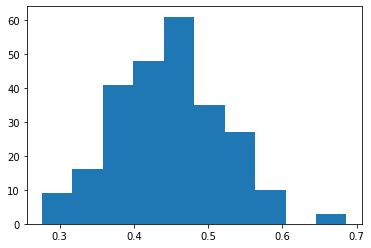

In [54]:
plt.hist((eig_bounds1-eig_bounds_true)/(eig_bounds_true))

### Wainwright calculation

In [14]:
# Wainwright calculation
p = 500
k = np.linspace(10, 200, 10, dtype=int)
sigma = np.linspace(0.1, 5, 25)
L = np.linspace(1, 50, 25)
c1 = 1
# Keep beta_min fixed.
beta_min = 5
beta = beta_min * np.ones(p)

# Store the number of samples and the corresponding errors
nw = np.zeros((k.size, sigma.size, L.size, 3, 5))
werrors = np.zeros((k.size, sigma.size, L.size, 3, 5))

for i1, k_ in enumerate(k):
    print(i1) 
    t0 = time.time()        
    for i2, ss in enumerate(sigma):
        for i3, l in enumerate(L):
            # Sparsify beta
            bb = sparsify_beta(beta, p, k_/p, seed = 1234)
            # Generate the appropriate covariance
            Sigma = gen_covariance(p, 1, p, l, 1)
            
            # Bound the minimum shcur complement eigenvalue
            inverse_eig_bound = bound_eigenvalue(np.linalg.inv(Sigma), k_)
            eig_bound = 1/inverse_eig_bound
            n_ = wgfunction(c1, p, k_, beta_min, np.sqrt(ss), eig_bound)
            error_ = np.exp(-c1 * (n_ - k_))                
            nw[i1, i2, i3] = n_
            werrors[i1, i2, i3] = error_
    print('%f s' % (time.time() - t0))


0
535.273914 s
1
539.561484 s
2
542.402190 s
3
542.100997 s
4
549.844115 s
5
562.362405 s
6
567.371670 s
7
566.893675 s
8
542.994687 s
9
539.640513 s


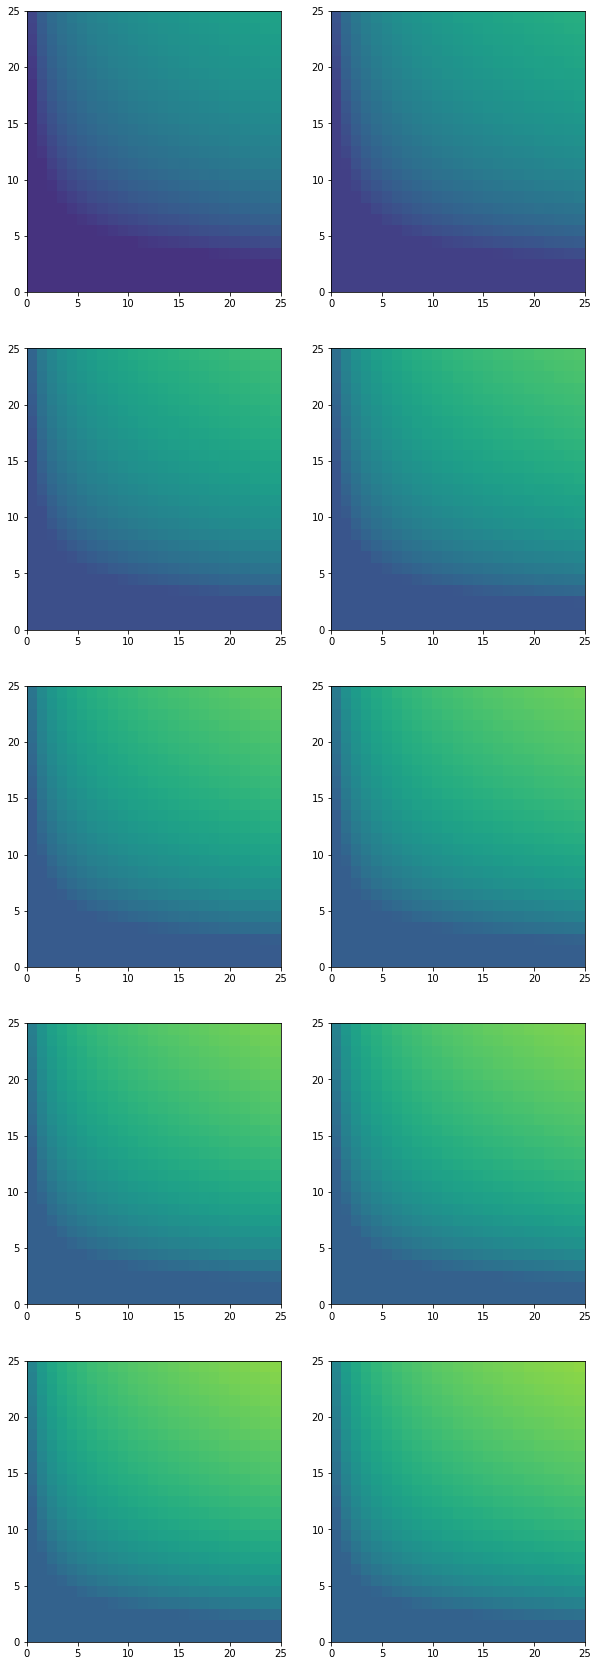

In [44]:
# For a few different sparsities, plot colormaps of n for different values of sigma and L:
fig, ax = plt.subplots(5, 2, figsize = (10, 30))

sparsities = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

for i in range(10):
    
    a = ax[np.unravel_index(i, (5, 2))]
    
    a.pcolormesh(np.log(ng[sparsities[i], :, :]), vmin = 10,  vmax = 20)

### Scarlett Calculation

In [67]:
# Can we tune the error thresholds to return a reasonable number of samples required?
# Scarlett calculation...

p = 250
k = np.linspace(10, 125, 5, dtype=int)
sigma = np.linspace(0.1, 5, 25)
rho = np.linspace(1/125, 1, 25)

# Keep beta_min fixed.
beta_min = 5
beta = beta_min * np.ones(p)
beta = beta[:, np.newaxis]

# Choices of delta_1 and delta_2
delta1 = np.exp(-p/np.linspace(1, 25))
delta2 = np.linspace(0, 1, 25)

# Store the number of samples and the corresponding errors
ns = np.zeros((k.size, sigma.size, rho.size, delta1.size, delta2.size))
serrors = np.zeros((k.size, sigma.size, rho.size, delta1.size, delta2.size))

for i1, k_ in enumerate(k):
    for i2, ss in enumerate(sigma):
        t0 = time.time()
        for i3, r in enumerate(rho):
            # Sparsify beta
            bb = sparsify_beta(beta, p, k_/p, seed = 1234).ravel()
            
            for didx1, d1 in enumerate(delta1): 
                for didx2, d2 in enumerate(delta2):
                    n_, error_ = serror_fn(d1, d2, p, k_, bb, np.sqrt(ss), r)            
                    ns[i1, i2, i3, didx1, didx2] = n_
                    serrors[i1, i2, i3, didx1, didx2] = error_
        print('%f s' % (time.time() - t0))
#             ns[i1, i2, i3] = ns_
#             serrors[i1, i2, i3] = serror

/home/akumar/anaconda3/envs/nse/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


9.732871 s
9.764640 s
9.722799 s
9.771952 s
9.664097 s
9.746440 s
9.680347 s
9.741851 s
9.897595 s
10.270584 s
9.901371 s
10.113198 s
10.132636 s
10.306338 s
10.454487 s
10.460800 s
10.064604 s
9.673414 s
9.759251 s
9.749035 s
9.784122 s
9.661981 s
10.202518 s
10.170004 s
10.232986 s
36.134844 s
36.557712 s
36.355778 s
36.253440 s
36.454286 s
36.513425 s
36.235207 s
35.869695 s
36.298367 s
36.196109 s
35.804452 s
35.929766 s
35.865088 s
35.397300 s
35.622266 s
35.617874 s
36.552942 s
36.238241 s
37.117571 s
35.485278 s
35.748917 s
35.765411 s
36.777807 s
35.667496 s
35.507541 s
63.103331 s
63.057485 s
63.078885 s
63.063326 s
63.247602 s
63.341070 s
63.875091 s
62.763930 s
63.108570 s
62.654706 s
63.138475 s
64.099220 s
63.636786 s
62.939548 s
62.909847 s
62.406568 s
62.519024 s
62.315558 s
63.104714 s
62.353676 s
62.547261 s
63.660254 s
65.591918 s
62.607203 s
62.125119 s
91.855994 s
92.625665 s
92.234954 s
90.105520 s
94.098761 s
93.250560 s
91.402892 s
90.648179 s
90.593091 s
91.0925

In [84]:
# How to visualize this data? First, we have to throw away all
# combinations of constants that lead to error probabilities > 1

valid_idxs = np.zeros((delta1.size, delta2.size))

for i1 in range(delta1.size):
    for i2 in range(delta2.size):
        
        if np.all(serrors[..., i1, i2] <= 1) and np.all(serrors[..., i1, i2] > 0):
            
            valid_idxs[i1, i2] = 1

In [ ]:
# We should double check the math once more, but perhaps this suggests
# an alternative approach. The sufficiency condition gives us the 
# minimum n for which sensible bounds can be placed on these random 
# quantities, but it does not restrict us from making n larger...

In [ ]:
# This suggests the following strategy: Choose a fixed delta 2, and
# let delta 1 go as exp(-p). Then, across the entire sample space
# of interest, we let the number of samples increase at each point 
# until we have driven the error probability to a fixed threshold

In [ ]:
# To be even more precise, we can adjust the eigenvalue bounds 
# to hold specifically for each subset dimension (defer for now)

In [98]:
from scipy.optimize import minimize_scalar

In [107]:
def optimize_n(thresh, *args):
    
    result = minimize_scalar(lambda n: np.abs(serror_fn(n, *args) - thresh))
    return result.x, result.fun + thresh

In [110]:
p = 500
k = np.linspace(10, 250, 6, dtype=int)
sigma = np.linspace(0.1, 5, 25)
rho = np.linspace(1/125, 1, 25)

# Keep beta_min fixed.
beta_min = 5
beta = beta_min * np.ones(p)
beta = beta[:, np.newaxis]

# Choices of delta_1 and delta_2
delta1 = np.exp(-p)

# The larger we make delta2, the larger the n threshold gets,
# but simultaneously the error probability gets driven down. Let's
# still explore the full range here to see what the tradeoff looks
# like. 
delta2 = np.linspace(0.01, 0.99, 50)

# Store the number of samples and the corresponding errors
ns = np.zeros((k.size, sigma.size, rho.size, delta2.size))
serrors = np.zeros((k.size, sigma.size, rho.size, delta2.size))

# Target error probability 
error_threshold = 1e-3

for i1, k_ in enumerate(k):
    for i2, ss in enumerate(sigma):
        t0 = time.time()
        for i3, r in enumerate(rho):
            # Sparsify beta
            bb = sparsify_beta(beta, p, k_/p, seed = 1234).ravel()            
            for didx2, d2 in enumerate(delta2):
                n_ = sgfunction(d1, d2, p, k_, bb, np.sqrt(ss), r)
                error_ = serror_fn(n_, d1, d2, p, k_, bb, np.sqrt(ss), r)            
                
                # n_ gives us the starting point
                # If we have already met the criteria, then stop
                if error_ < error_threshold:
                    ns[i1, i2, i3, didx2] = n_
                    serrors[i1, i2, i3, didx2] = error_
                else:
                    # Solve for the smallest n that lets us 
                    # meet the threshold via an optimization problem
                    n_, error_ = optimize_n(error_threshold, 
                                    d1, d2, p, k_, bb, np.sqrt(ss), r)
                    ns[i1, i2, i3, didx2] = n_
                    serrors[i1, i2, i3, didx2] = error_
                    
        print('%f s' % (time.time() - t0))


#             ns[i1, i2, i3] = ns_
#             serrors[i1, i2, i3] = serror

7.593412 s
7.957234 s
8.250808 s
8.287996 s
8.634308 s
9.088949 s
9.280356 s
9.380968 s
9.351605 s
9.871361 s
9.592460 s
9.292126 s
9.263225 s
9.675983 s
9.423051 s
9.614403 s
9.980696 s
10.371444 s
9.943914 s
9.995961 s
10.002049 s
10.664769 s
9.924854 s
9.928330 s
9.996491 s
60.514586 s
62.293299 s
64.259956 s
65.936649 s
69.384673 s
69.416064 s
69.147382 s
70.775889 s
72.140293 s
72.634277 s
73.489234 s
75.632807 s
76.245972 s
77.154013 s
75.642265 s
78.263023 s
78.073848 s
78.447162 s
79.274993 s
78.748873 s
80.044851 s
80.625082 s
83.088411 s
82.043502 s
82.800264 s
114.236334 s
116.618524 s
116.764612 s
119.191181 s
124.201221 s
129.835732 s
131.584786 s
131.925855 s
131.830499 s
136.565814 s
136.440727 s
136.676888 s
135.613735 s
137.596444 s
138.681694 s
139.796579 s
143.013006 s
140.178091 s
141.623270 s
143.169349 s
144.179708 s
145.286124 s
150.482225 s
147.337248 s
149.589443 s
162.006692 s
174.339845 s
175.154308 s
184.036800 s
177.688925 s
181.077438 s
183.051846 s
186.13

In [9]:
import pickle

In [10]:
# with open('scarlett_boundaries.dat', 'wb') as f:
#     f.write(pickle.dumps(ns))
#     f.write(pickle.dumps(serrors))

In [13]:
with open('scarlett_boundaries.dat', 'rb') as f:
    ns = pickle.load(f)
    serrors = pickle.load(f)

In [14]:
# Plot colormaps of the results for the n necessary
ns.shape

(6, 25, 25, 50)

In [17]:
np.max(np.log(ns))

28.50404931420962

In [16]:
np.min(ns)

9.202526788880567

In [37]:
np.argmin(np.log(ns[0, 0, :, :]), axis = -1)

array([47, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
       49, 49, 49, 49, 49, 49, 49, 49])

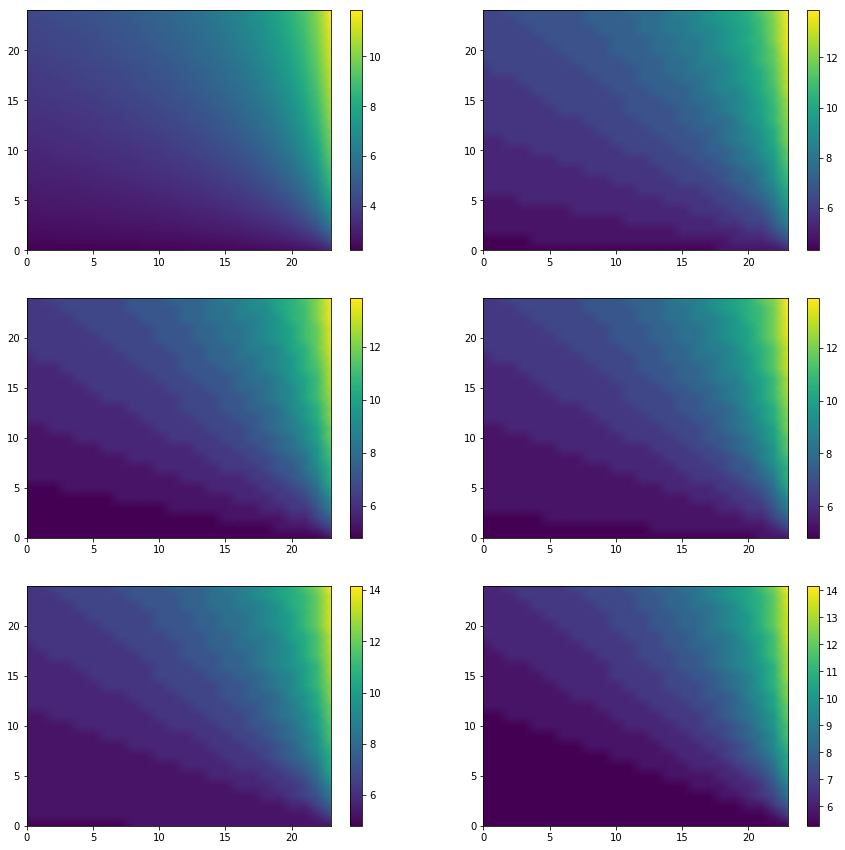

In [33]:
fig, ax = plt.subplots(3, 2, figsize = (15, 15))

for i in range(ns.shape[0]):
    
    a = ax[np.unravel_index(i, (3, 2))]
    h = a.pcolormesh(np.log(np.amin(np.flip(ns, axis = 2)[i, :, :-1,:], axis =-1)), shading = 'gouraud')
    fig.colorbar(h, ax=a)

In [ ]:
# Partial recovery, rescaling of beta^T beta to 1, vary alpha

In [24]:
def n_threshold(delta1, delta2, p, k, alpha_max, recovery_fraction):
    # When all the beta are the same, gamma0 becomes 0
    gamma0 = 0
    
    dmax = int((1 - recovery_fraction) * k)
    
    nl = np.zeros(np.arange(max(1, dmax), k).size)

    for l in range(max(1, dmax), k):
        alpha = alpha_max * l/k
        numerator = np.log(binom(p - k, l)) + 2 * np.log(k/delta1 * binom(k, l)) + gamma0
        denominator = 1/2 * (1 + alpha**2) * (1 - delta2)
        try:
            nl[l - max(1, dmax)] = numerator/denominator
        except:
            pdb.set_trace()

    try:
        return np.max(nl)
    except:
        pdb.set_trace()

In [25]:
def error_fn(n, delta1, delta2, p, k, alpha_max, recovery_fraction):
    
    dmax = int((1 - recovery_fraction) * k)
    
    perror = 0
    for l in range(max(1, dmax), k):
        alpha = alpha_max * l/k
        error_exponent = -1/16 * delta2**2 * n * np.log(1 + alpha**2)**2\
        /(alpha * (1 + alpha)/(1 + alpha**2) * (8*(1 + alpha)/(1 + alpha**2) + delta2/2 * np.log(1 + alpha**2)))
        perror += 2 * binom(k, l) * np.exp(error_exponent)
    
    perror += 2 * delta1
    
    return perror

In [26]:
def optimize_n2(thresh, nmin, *args):
    
    result = minimize_scalar(lambda n: (error_fn(n, *args) - thresh)**2, bounds=[nmin, np.inf])
    return result.x, result.fun + thresh

In [29]:
p = 250
k = 25

# Assumes that rho is no smaller than 0.01, and that sigma gets no larger than 1 (SNR 1)
alpha_max = np.logspace(1, -2, 250)

recovery_fraction = np.linspace(0.75, 1, 25)

error_thresholds = np.array([0.05, 0.01, 0.001])

# Choices of delta_1 and delta_2
delta1 = np.exp(-p)

# The larger we make delta2, the larger the n threshold gets,
# but simultaneously the error probability gets driven down. Let's
# still explore the full range here to see what the tradeoff looks
# like. 
delta2 = np.linspace(0.01, 0.99, 50)

# Store the number of samples and the corresponding errors
ns = np.zeros((error_thresholds.size, recovery_fraction.size, alpha_max.size, delta2.size))
serrors = np.zeros((error_thresholds.size, recovery_fraction.size, alpha_max.size, delta2.size))

for i1, et in enumerate(error_thresholds):
    for i2, rf in enumerate(recovery_fraction):
        t0 = time.time()
        for i3, am in enumerate(alpha_max):
            for didx2, d2 in enumerate(delta2):
                n_ = n_threshold(delta1, d2, p, k, am, rf)
                error_ = error_fn(n_, delta1, d2, p, k, am, rf)            

                # n_ gives us the starting point
                # If we have already met the criteria, then stop
                if error_ < et:
                    ns[i1, i2, i3, didx2] = n_
                    serrors[i1, i2, i3, didx2] = error_
                else:
                    # Solve for the smallest n that lets us 
                    # meet the threshold via an optimization problem
                    n_, error_ = optimize_n2(et, n_,
                                    delta1, d2, p, k, am, rf)
                    ns[i1, i2, i3, didx2] = n_
                    serrors[i1, i2, i3, didx2] = error_

        print('%f s' % (time.time() - t0))

81.560929 s
89.122939 s
89.331993 s
88.594509 s
88.304040 s
97.009669 s
97.388871 s
96.853952 s
97.082602 s
108.264266 s
107.186360 s
106.068918 s
106.304540 s
119.314618 s
119.283288 s
119.244313 s
119.218437 s
138.260912 s
137.994100 s
138.376876 s
137.746698 s
137.437696 s
137.709640 s
137.741477 s
137.638948 s
80.956890 s
88.481896 s
88.752782 s
88.604973 s
88.605807 s
97.477725 s
97.765127 s
97.708673 s
97.806340 s
107.344835 s
107.581851 s
107.111265 s
107.414473 s
119.863112 s
120.307630 s
120.226470 s
120.375135 s
141.212028 s
141.824587 s
141.312986 s
141.253197 s
140.950663 s
140.946307 s
141.103476 s
140.545049 s
82.669605 s
90.852338 s
90.824451 s
90.842495 s
90.880991 s
99.797302 s
99.724944 s
99.403878 s
99.463791 s
110.012410 s
109.765501 s
110.080036 s
109.817410 s
123.987171 s
123.563908 s
123.960161 s
123.673110 s
143.752746 s
143.795704 s
144.244145 s
144.118831 s
143.649538 s
143.836155 s
143.781489 s
143.491136 s


In [30]:
import pickle

In [32]:
with open('alpha_max.dat', 'wb') as f:
    f.write(pickle.dumps(ns))
    f.write(pickle.dumps(serrors))

### Optimization Approach

In [ ]:
# Seems ok...., we need to re-do with a few modifications. First, we need to determine what a reasonable 
# range of the singal to noise and rho is. Second, we need to extend to partial recovery.
# We also need to understand how these limits scale as a function of the error threshold selected. I.e., if we
# drop the threshold by an order of magnitude (from 1e-3 to 1e-2), how does this affect the number of samples
# required? 

In [52]:
def error_loss_fn(n, delta2, threshold, delta1, p, k, beta, sigma, rho):
    beta = np.abs(beta[beta !=0])
    beta = np.sort(beta)
    perror = 0
    for l in range(1, k):
        beta_min = np.linalg.norm(beta[:l])**2
        alpha = beta_min * rho/sigma**2
        error_exponent = -1/16 * delta2**2 * n * np.log(1 + alpha**2)**2\
        /(alpha * (1 + alpha)/(1 + alpha**2) * (8*(1 + alpha)/(1 + alpha**2) + delta2/2 * np.log(1 + alpha**2)))
        perror += 2 * binom(k, l) * np.exp(error_exponent)
    perror += 2 * delta1
    return (perror - threshold)**2

In [87]:
# Same as above but create a pytorch tensor out of it so we can call gradient function
def error_loss_fn_tensor(n, delta2, threshold, delta1, p, k, beta, sigma, rho):
    n = torch.tensor(n, requires_grad=True)
    delta2 = torch.tensor(delta2, requires_grad=True)
        
    beta = np.abs(beta[beta !=0])
    beta = np.sort(beta)
    perror = torch.tensor(0, dtype = torch.float32)

    for l in range(1, k):
        beta_min = np.linalg.norm(beta[:l])**2
        alpha = torch.tensor(beta_min * rho/sigma**2)
        error_exponent = -1/16 * delta2**2 * n * np.log(1 + alpha**2)**2\
        /(alpha * (1 + alpha)/(1 + alpha**2) * (8*(1 + alpha)/(1 + alpha**2) + delta2/2 * np.log(1 + alpha**2)))
        perror += 2 * torch.tensor(binom(k, l)) * torch.exp(error_exponent)
    
    perror += 2 * delta1
        
    loss = (perror - threshold)**2        

    perror.backward()
    dpdn = n.grad.detach().cpu().numpy().astype(float)
    dpddelta2 = delta2.grad.detach().cpu().numpy().astype(float)
    
    return np.array([dpdn, dpddelta2])

In [82]:
# Call this once before optimization to determine the max index
def det_max_index(p, k, beta, sigma, rho):
    
    # these values don't particularly matter...
    delta1 = np.exp(-p)
    delta2 = 0.5
    
    gamma0 = k * np.log(np.unique(beta[np.nonzero(beta)]))
    # Sort beta
    beta = np.abs(beta[beta != 0])
    beta = np.sort(beta)
                
    # Iterate over all possible subset dimensions
    nl = np.zeros(k - 1)    
    for l in range(1, k):
        # Find the magnitude of the first l components
        beta_min = np.linalg.norm(beta[:l])**2
        alpha = beta_min * rho/sigma**2
        numerator = np.log(binom(p - k, l)) + 2 * np.log(k/delta1 * binom(k, l)) + gamma0
        denominator = 1/2 * (1 + alpha**2) * (1 - delta2)
        nl[l - 1] = numerator/denominator
    
    max_index = np.argmax(nl)
    
    beta_min = np.linalg.norm(beta[:np.arange(1, k)[max_index]])**2
    alpha_max = beta_min * rho/sigma**2
    
    return np.argmax(nl), gamma0, alpha_max    

In [96]:
# Relationship constraining n and delta2
def n_constraint(n, delta2, index, delta1, p, k, alpha, gamma0):
    
    l = np.arange(1, k)[index]
    
    numerator = np.log(binom(p - k, l)) + 2 * np.log(k/delta1 * binom(k, l)) + gamma0
    denominator = 1/2 * (1 + alpha**2) * (1 - delta2)
    
    return n - numerator/denominator

In [106]:
# Jacobian of constraint
def n_constraint_jac(n, delta2, index, delta1, p, k, alpha, gamma0):
    
    l = np.arange(1, k)[index]
    
    numerator = np.log(binom(p - k, l)) + 2 * np.log(k/delta1 * binom(k, l)) + gamma0

    denominator1 = 1/2 * (1 + alpha**2) * (1 - delta2)
    denominator2 = 1/2 * (1 + alpha**2) * (1 - delta2)**2

    return np.array([1 - numerator/denominator2, n - numerator/denominator2]).T

In [124]:
def optimize_n_delta(threshold, delta1, p, k, beta, sigma, rho):
    
    # First determine the max index and constants gamm0, alpha
    idx, gamma0, alpha = det_max_index(p, k, beta, sigma, rho)
        
    # Bound
    bnd = Bounds([0, 1e-6], [np.inf, 1 - 1e-6])
    
    # Constraint
    ineq_constr = {'type' : 'ineq', 
                   'fun' : lambda x : n_constraint(x[0], x[1], idx, delta1, p, k, alpha, gamma0),
                   'jac': lambda x : n_constraint_jac(x[0], x[1], idx, delta1, p, k, alpha, gamma0)}    
    
    # Objective Function
    obj_fn = lambda x : error_loss_fn(x[0], x[1], threshold, delta1, p, k, beta, sigma, rho)
    obj_fn_grad = lambda x: error_loss_fn_tensor(x[0], x[1], threshold, delta1, p, k, beta, sigma, rho)
    
    # Initial guess
    delta2_0 = 0.95
    n0 = sgfunction(delta1, delta2_0, p, k, beta, sigma, rho)
    
    result = minimize(obj_fn, np.array([n0, delta2_0]), method='SLSQP',
                      jac = obj_fn_grad, constraints=[ineq_constr], bounds=bnd)
    pdb.set_trace()
    return result.x

In [167]:
p = 250
sigma_sq = np.linspace(0.1, 5, 25)
rho = np.linspace(1/125, 1, 25)
error_thresholds = np.array([0.05, 0.01, 0.001])

# Keep beta_min fixed.
beta_min = 5
beta = beta_min * np.ones(p)
beta = beta[:, np.newaxis]

# Choices of delta_1 and delta_2
delta1 = np.exp(-p)

# Store the number of samples and the corresponding errors
ns = np.zeros((error_thresholds.size, sigma_sq.size, rho.size))
delta2 = np.zeros((error_thresholds.size, sigma_sq.size, rho.size))

k = 25
bb = sparsify_beta(beta, p, k/p, seed = 1234).ravel()            

for i1, et in enumerate(error_thresholds):
    for i2, ss in enumerate(sigma_sq):
        t0 = time.time()
        for i3, r in enumerate(rho):

            # Jointly optimize the error function over delta2 and n. 
            res = optimize_n_delta(et, delta1, p, k, bb, np.sqrt(ss), r)
            ns[i1, i2, i3] = res[0]
            delta2[i1, i2, i3] = res[1]
            
        print('%f s' % (time.time() - t0))

> <ipython-input-124-b717d839723c>(25)optimize_n_delta()
-> return result.x
(Pdb) quit()


BdbQuit: 

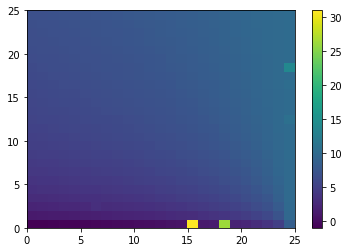

In [119]:
plt.pcolormesh(np.log(np.flip(ns[0,...], axis=-1)))
plt.colorbar()

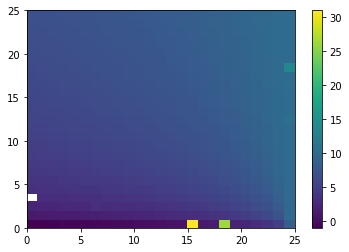

In [120]:
plt.pcolormesh(np.log(np.flip(ns[1,...], axis=-1)))
plt.colorbar()

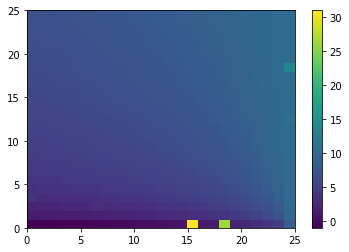

In [121]:
plt.pcolormesh(np.log(np.flip(ns[2,...], axis=-1)))
plt.colorbar()